In [1]:
import sys
sys.path.append('../qick/qick_lib/')

from spectrum_v1 import *

import numpy as np

import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift

In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./spectrum_v1.bit', ignore_version=True, force_init_clks=False)

F1 = 240.002, Y1 = -11.735


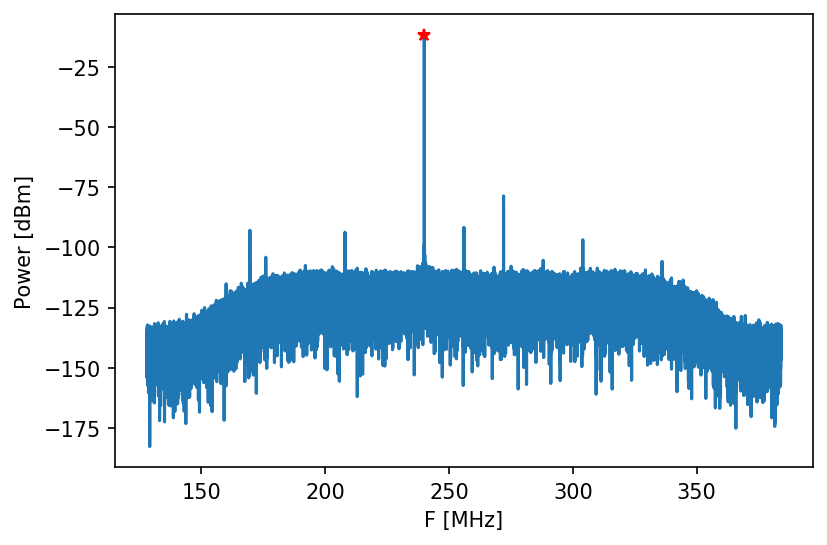

In [155]:
#################################
### Single Channel PFB output ###
#################################
# Output frequency.
fout = 240
soc.iq.set_iq(i=0.99,q=0.99)
soc.mixer.set_freq(f=fout,tile=1,dac=3)

# PFB channel.
K = soc.pfb.freq2ch(f = fout)
soc.chsel.set(K)

# Channel center frequency.
FC = soc.pfb.ch2freq(K)

# Get data.
[xi,xq] = soc.buff.get_data()
x = xi + 1j*xq

# ADU to V.
# 500mV --> 2^15
x = x*0.5/2**15

# Spectrum.
w = np.hanning(len(x))
Aw = len(w)/np.sum(w)
xw = Aw*x*w
Y = fftshift(fft(xw)/len(xw))
F = np.linspace(-soc.pfb.get_fb()/2,soc.pfb.get_fb()/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = soc.findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(1,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

Iteration K = 0
Iteration K = 1
Iteration K = 2
Iteration K = 3
Iteration K = 4
Iteration K = 5
Iteration K = 6
Iteration K = 7
Iteration K = 8
Iteration K = 9
Iteration K = 10
Iteration K = 11
Iteration K = 12
Iteration K = 13
Iteration K = 14
Iteration K = 15


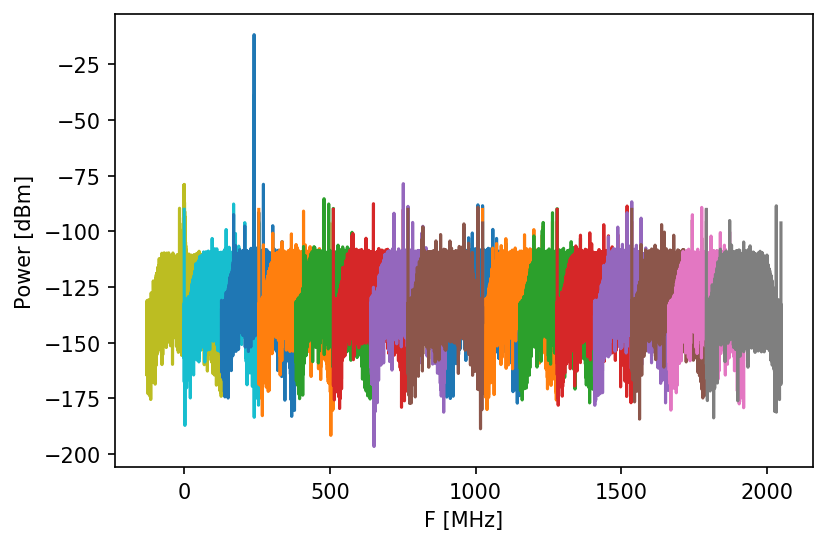

In [156]:
####################################
### Multiple Channels PFB output ###
####################################
# Output frequency.
fout = 240
soc.iq.set_iq(i=0.99,q=0.99)
soc.mixer.set_freq(f=fout,tile=1,dac=3)

# Channels to plot.
K = np.arange(soc.pfb.N)

plt.figure(1,dpi=150)

# Frequency and amplitude vectors.
FF = []
AA = []
for KK in K:
    print("Iteration K = %d" %KK)
    # PFB channel.    
    soc.chsel.set(KK)
    
    # Channel center frequency.
    fck = soc.pfb.ch2freq(KK)
    
    # Get data.
    [xi,xq] = soc.buff.get_data()
    x = xi + 1j*xq

    # ADU to V.
    # 500mV --> 2^15
    x = x*0.5/2**15

    # Spectrum.
    w = np.hanning(len(x))
    Aw = len(w)/np.sum(w)
    xw = Aw*x*w
    Y = fftshift(fft(xw)/len(xw))
    F = np.linspace(-soc.pfb.get_fb()/2,soc.pfb.get_fb()/2,len(Y))

    # Normalize to dBm.
    R = 50;
    Y = 10*np.log10((np.abs(Y)**2)/(2*R*1e-3));
    
    Fk = F+fck
    plt.plot(Fk,Y)

plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

F1 = 440.003, Y1 = -12.432
FFT Resolution: 15.625 kHz


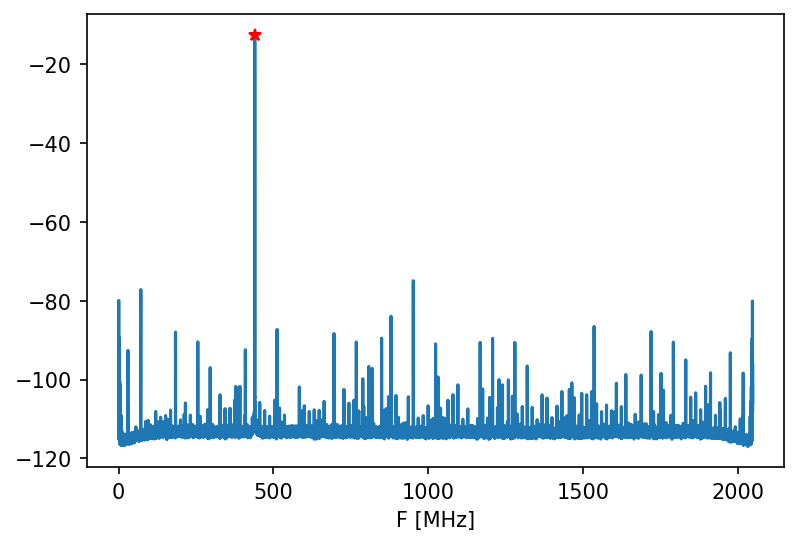

In [189]:
######################################
### Full Bandwidth ACC FULL output ###
######################################
# Output frequency.
fout = 440
soc.iq.set_iq(i=0.99,q=0.99)
soc.mixer.set_freq(f=fout,tile=1,dac=3)

# Get data.
x = soc.acc_full.single_shot(100)
x = np.roll(x, -int(soc.acc_full.FFT_N/4))

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by FFT length.
x = x/(soc.acc_full.FFT_N)**2

# Spectrum.
Y = fftshift(x)
F = np.linspace(0,soc.pfb.get_fs(),len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = soc.findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1,Y1));

plt.figure(1,dpi=150)
plt.plot(F,Y)
plt.plot(F1,Y1,'r*');
plt.xlabel("F [MHz]");

print('FFT Resolution: {} kHz'.format(1000*soc.pfb.get_fb()/soc.acc_full.FFT_N))

F1 = 256.200, Y1 = -16.265
FFT Resolution: 19.53125 Hz


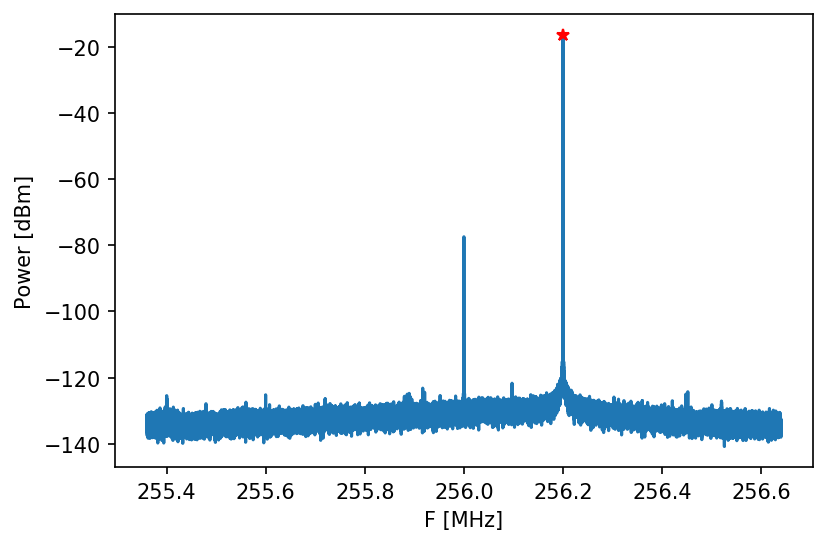

In [187]:
###############################
### Single Channel Zoom FFT ###
###############################
# Output frequency.
fout = 270
soc.iq.set_iq(i=0.5,q=0)
soc.mixer.set_freq(f=fout,tile=1,dac=3)

# PFB channel.
K = soc.pfb.freq2ch(f = fout)
soc.chsel.set(K)

# Channel center frequency.
FC = soc.pfb.ch2freq(K)

# DDS + CIC configuration.
soc.ddscic.outsel(data="product", cic="yes")
soc.ddscic.decimation(200)
soc.ddscic.ddsfreq(f=14e6-200e3)
soc.ddscic.set_qprod(14)

# Get data.
x = soc.acc_zoom.single_shot(10)

# ADU to V.
# 500mV --> 2^15
x = x*(0.5/2**15)**2

# Scale by window gain.
x = x*(soc.fft.Aw)**2*(2**16)**2

# Scale by FFT length.
x = x/(soc.acc_zoom.FFT_N)**2

# Sampling frequency.
fs = soc.pfb.get_fb()/soc.ddscic.get_decimation()

# Spectrum.
Y = x
F = np.linspace(-fs/2,fs/2,len(Y))

# Normalize to dBm.
R = 50;
Y = 10*np.log10((np.sqrt(Y)**2)/(2*R*1e-3));

# Max.
[F1,Y1] = soc.findPeak(F,Y);
print('F1 = {:.3f}, Y1 = {:.3f}'.format(F1+FC,Y1));

plt.figure(1,dpi=150)
plt.plot(F+FC,Y)
plt.plot(F1+FC,Y1,'r*');
plt.xlabel("F [MHz]");
plt.ylabel("Power [dBm]");

print('FFT Resolution: {} Hz'.format(1000*1000*fs/soc.acc_zoom.FFT_N))

In [184]:
65536*1/fs

51200.0